# EY NextWave Data Science Competition 2019 - Final Submission

- <a href='#1'>1. Introduction</a>  
    - <a href='#1-1'>1.1. Problem Statement</a>
- <a href='#2'>2. General Overview </a>
- <a href='#3'>3. Importing Libraries and Data </a>
- <a href='#4'> 4. Feature Extraction</a>
    - <a href='#4-1'> 4.1. Distancial-directional Calculations</a>
- <a href='#7'> 7. Baseline Models </a>
    - <a href='#7-1'> 7.1. Logistic Regression</a>
    - <a href='#7-2'> 7.2. Random Forest</a>
    - <a href='#7-3'> 7.3. Gradient Boosting</a>
    - <a href='#7-4'> 7.4. Feature Importances </a>
- <a href='#9'> 9. Saving Train and Test Set preprocessed  </a>
- <a href='#10'> 10. Conclusion </a>

## <a id='3'>3. Importing Libraries and Data</a>

In [4]:
#!pip install tqdm
#!conda install shapely descartes geopandas -y

In [114]:
import warnings
import math
import re

# visualiztion tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

# data preprocessing tools
import pandas as pd
from shapely.geometry import Point
import numpy as np


tqdm.pandas()
plt.style.use('seaborn')
warnings.filterwarnings("ignore")

%run ../src/utils.py

In [115]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)

train.shape, test.shape

((814262, 11), (202937, 11))

In [116]:
data = pd.concat([train, test], axis=0)

data.shape

(1017199, 11)

## <a id='4'>4. Feature Extraction </a>

In this section, we will build new features for our data. Here we will explore the time component of the data, as well as distances, angles, how each trajectory relates to the city center, etc. Also, in order to achieve a better score, we need to construct the data accordingly to its sequential format.

### <a id='4-1'>4.1. Distancial-directional Calculations </a>

Distance is a primary factor in comparing two points in a cartesian plane. It is then reasonable to calculate a couple of different distance formulas for points throughout our dataset:

- Euclidean distance is defined as length of the smallest straight line connecting two points in cartesian space, e.g. points $p$ and $q$, being:
$$
d(p, q) = d(q, p) = \sqrt{\sum_{i=1}^{n}(q_i - p_i)^2}
$$
- Manhattan distance, also known as taxicab metric and L1 distance, comprises the sum of projections of a given line in each of its plane's axes:
$$
d(X, Y) = \sum_{i=1}^{n}|x_i - y_i|^p
$$
- And, finally, Haversine, which gives the distance between two points over a spherical surface.
$$
d = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos(\varphi_1) \cos(\varphi_2)\sin^2\left(\frac{\lambda_2 - \lambda_1}{2}\right)}\right)
$$

In [117]:
data['euclidean_distance'] = euclidean(data.x_entry.values, data.y_entry.values, data.x_exit.values, data.y_exit.values)

data['manhattan_distance'] = manhattan(data.x_entry.values, data.y_entry.values, data.x_exit.values, data.y_exit.values)

data['harvesine_distance'] = haversine(data.x_entry.values, data.y_entry.values, data.x_exit.values, data.y_exit.values)

In [118]:
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidean_distance,manhattan_distance,harvesine_distance
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,42364.863118,43047.231426,376.999025
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,2989.643628,3841.346373,10165.680722
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,725.658561,776.090116,9001.777133
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,1804.576849,1874.414413,2668.005882


Some patterns in data distribution can already be analyzed from theses distance computations. Let's analyze the Euclidean distance values among train and test data to gain a closer perception.

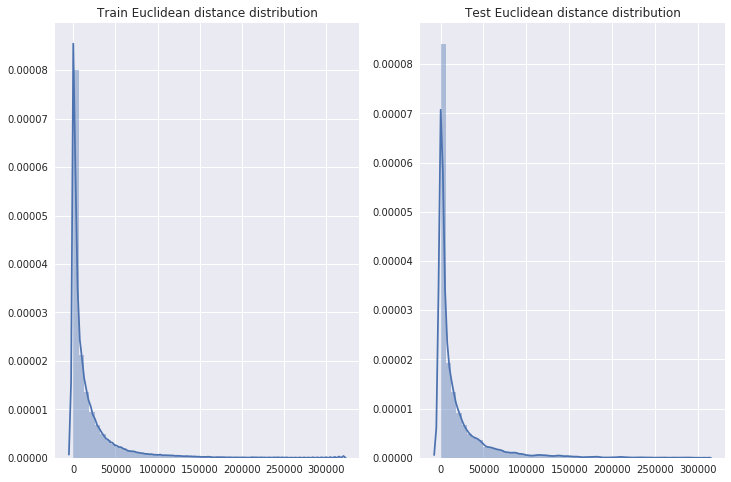

In [119]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8))
ax1.set_title('Train Euclidean distance distribution')
ax2.set_title('Test Euclidean distance distribution')

distplot(data[data.hash.isin(train.hash)], 'euclidean_distance', ax=ax1)
distplot(data[data.hash.isin(test.hash)], 'euclidean_distance', ax=ax2)

In [120]:
# Percentage of 0-valued distances among all non-NaN euclidean values.
data[data.euclidean_distance == 0.0].shape[0] / data[~np.isnan(data.euclidean_distance)].shape[0]

0.5339448440759431

In [121]:
# Percentage of 0-valued distances having time entry equal to time exit
data[
    (data.euclidean_distance == 0.0) & (data.time_exit == data.time_entry)
].shape[0] / data[data.euclidean_distance == 0.0].shape[0]

0.9975972568364897

The above shows us that more than half of _all_ filled distances in our sets are 0-valued - and basically all those 0 distance trajectories start and end **at the same time**.

This means that target predictions over those points would only need to check whether the trajectory starts inside the city center. Since the coordinates will stay the same, so will that status.

For these reasons, we will sample as trainable data only points having euclidean distances different than 0.

In [122]:
percentage_zeros = data[data.euclidean_distance==0]
percentage_zeros = (percentage_zeros.groupby('hash').trajectory_id.count() 
                    / data.groupby('hash').trajectory_id.count()).reset_index()
percentage_zeros.columns = ['hash', 'zeros_in_trajectory']

In [123]:
data = data[data.euclidean_distance!=0]
data.shape

(491966, 14)

#### <a id='4-1-1'>4.1.1. City Center Midpoint Distances</a>

Since we want to determine a trajectory's end coordinates as being either in or out of the city center, current-to-center-midpoint distance can be a determinant feature. Let's compute those differences.

In [124]:
data['eucl_dist_cc_entry'] = euclidean(data.x_entry.values, data.y_entry.values, center['x_mid'], center['y_mid'])
data['eucl_dist_cc_exit'] = euclidean(data.x_exit.values, data.y_exit.values, center['x_mid'], center['y_mid'])

data['manh_dist_cc_entry'] = manhattan(data.x_entry.values, data.y_entry.values, center['x_mid'], center['y_mid'])
data['manh_dist_cc_exit'] = manhattan(data.x_exit.values, data.y_exit.values, center['x_mid'], center['y_mid'])

data['havr_dist_cc_entry'] = haversine(data.x_entry.values, data.y_entry.values, center['x_mid'], center['y_mid'])
data['havr_dist_cc_exit'] = haversine(data.x_exit.values, data.y_exit.values, center['x_mid'], center['y_mid'])

data['eucl_diff_cc_exit_entry'] = data.eucl_dist_cc_exit - data.eucl_dist_cc_entry
data['manh_diff_cc_exit_entry'] = data.manh_dist_cc_exit - data.manh_dist_cc_entry
data['havr_diff_cc_exit_entry'] = data.havr_dist_cc_exit - data.havr_dist_cc_entry

In [125]:
data['x_diff_entry'] = data.x_entry.values - center['x_mid']
data['x_diff_exit'] = data.x_exit.values - center['x_mid']

data['y_diff_entry'] = data.y_entry.values - center['y_mid']
data['y_diff_exit'] = data.y_exit.values - center['y_mid']

#### <a id='4-1-2'>4.1.2. City Center Midpoint Directions</a>

Differences from entry and exit points to center middle can also be angularly significant as that can reveal how trajectories are bent towards the midpoint.

In [126]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [127]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

#### <a id='4-1-3'>4.1.3. City Center Border Distances</a>

Our predefined city center is a rectangle (see below). Each of its borders represent the very boundaries that will ultimately define if a trajectory is inside the center - or not - so it seems logical to compute the minimum distance to all borders.

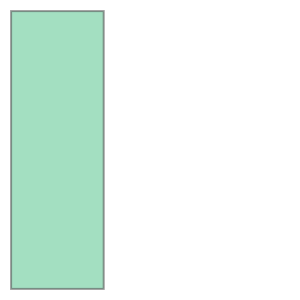

In [128]:
center_polygon

In [129]:
def distance_to_border(x, y, side):
    return center[side + '_border'].distance(Point(x, y))

for side in ['left', 'right', 'lower', 'upper']:
    data[f'distance_{side}_border'] = [distance_to_border(x, y, side=side) for x, y in zip(data.x_entry, data.y_entry)]

#### <a id='4-1-4'>4.1.4. City Center Vertex Angles</a>

Onto the same motivation for the above, we will also compute the angles from every entry w.r.t. the city center's **vertexes**. That'll generate features more connected to the directional aspects of entry coordinates for each of those vertexes.

In [130]:
data['last_x_entry'] = data.groupby('hash').x_exit.shift(1)
data['last_y_entry'] = data.groupby('hash').y_exit.shift(1)

angle_cols = [
    'cc_middle_angle', 'cc_xmin_ymin_angle', 'cc_xmax_ymin_angle', 'cc_xmin_ymax_angle', 'cc_xmax_ymax_angle'
]

data = data.reindex(columns=data.columns.tolist() + angle_cols)

data = data.progress_apply(entry_to_center_angles, axis=1)

data = data.drop(columns=['last_x_entry', 'last_y_entry'])

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.102748,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-2.946875,54012.799354,59966.283785,54012.799354,113775.281047,0.137059,0.038653,0.188293,0.042244,0.310604
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-2.851747,25386.747582,35858.533322,25386.747582,84874.048910,0.198812,0.120334,0.476339,0.057555,0.234039
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-2.839174,24146.972686,34984.767305,24146.972686,83601.282594,0.173281,0.132425,0.711798,0.044184,0.184758


In [131]:
# Angle conversion: rads to degrees
data[angle_cols] = data[angle_cols] * 180.0 / np.pi
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,cc_middle_angle,cc_xmin_ymin_angle,cc_xmax_ymin_angle,cc_xmin_ymax_angle,cc_xmax_ymax_angle
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-0.102748,114925.024135,116633.059928,174924.969304,114924.969304,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-2.946875,54012.799354,59966.283785,54012.799354,113775.281047,7.852886,2.214659,10.788397,2.420383,17.796301
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-2.851747,25386.747582,35858.533322,25386.747582,84874.048910,11.391105,6.894649,27.292186,3.297664,13.409474
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-2.839174,24146.972686,34984.767305,24146.972686,83601.282594,9.928271,7.587407,40.782997,2.531528,10.585844


### <a id='4-2'>4.2. Time-wise Features </a>

Trajectories in our context are also deeply rooted in their temporal distributions. Let us then start exploring those features by isolating them in hour, minute, and delta values.

In [132]:
data['minute_entry'] = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))
data['minute_exit']  = data.time_exit.progress_apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.progress_apply(lambda x: int(x.split(':')[0]))
data['hour_exit']  = data.time_exit.progress_apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit']  = pd.to_timedelta(data.time_exit)

data['timedelta'] = (data.time_exit - data.time_entry) / pd.Timedelta(minutes=1)

#### <a id='4-2-1'>4.2.1. Time-wise: Continuous Features </a>

The relationship of a trajectory with time may not only be related to the discrete (integer) representation of entry/exit occurence times: continuous representations of those will supposedly lead us closer to revealing different patterns spread throughout different parts of an hour or minute.

In [133]:
data['hours_continuous'] = [t / pd.Timedelta(hours=1) for t in data.time_entry]
data['minutes_continuous'] = [t / pd.Timedelta(minutes=1) for t in data.time_entry]

### <a id='4-3'>4.3. Quadrants </a>

Trajectory sparsity along the city center is an important factor when trying to identify patterns that may be enclosed in a particular center quadrant. Let us compute features acknowledging such relation by dividing the city center in four quadrants.

In [134]:
def quadrant_computation(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        
for quadrant in ['first', 'second', 'third', 'fourth']:
    data[quadrant+'_quadrant_entry'] = [quadrant_computation(x, y, which=quadrant) 
                                        for x, y in zip(data.x_entry, data.y_entry)]

### <a id='4-4'>4.4. Center features </a>

We can work with features related to center computation. Here, two more features are created: center_permanency, that encloses how much of the trajectory was inside the city center and has_crossed_city, that will indicate that a trajectory crossed city center.

In [135]:
data['center_permanency'] = data.progress_apply(center_permanency, axis=1)
data['crossed_city'] = data.progress_apply(crossed_city, axis=1)

### <a id='4-5'>4.5. Blind trajectories features </a>

One of the major issues in the data set and in the problem statement is that a lot of devices IDs have blind trajectories, that is, they have different positions for the last exit and current entry postions. Therefore, we need to explore data to acquire information regarding this blind spots. 

In [136]:
# time passed between blind spots
data['timedelta_blind'] = (data.time_entry - data.time_exit.shift(1)) / pd.Timedelta(minutes=1)

# delta for x and y blind
data['x_delta_blind'] = data.x_entry - data.groupby('hash').x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.groupby('hash').y_exit.shift(1)

data['euclidean_distance_blind'] = np.sqrt(np.power(data.x_delta_blind.values, 2) 
                                     + np.power(data.y_delta_blind.values, 2))

data['manhattan_distance_blind'] = (np.abs(data.x_delta_blind.values) 
                                + np.abs(data.y_delta_blind.values))

In [137]:
data['trajectory_number'] = data.trajectory_id.progress_apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

### <a id='4-6'>4.6. Trajectories' Origin Point Features</a>

It is a logical estimate that an extensive group in all recorded trajectories will eventually return to their origin point in the day - relating, in this case, to a person's return home. Dealing with paths distributed in space and time, the current-point to origin-point correlation levels hold a considerable chance to be proportional to any either spatial coordinates, time, or both.

With that in mind, let us then compute features focused on current-to-origin point differences.

In [138]:
col_subset = ['time_entry', 'time_exit', 'x_entry', 'y_entry', 'x_exit', 'y_exit']
data[[f'last_{c}' for c in col_subset]] = data.groupby('hash')[col_subset].shift(1)

origin_points = data.groupby('hash').nth(0)[col_subset]
origin_points.columns = [f'origin_{c}' for c in col_subset]

In [139]:
if data.columns.contains('origin_time_entry'):
    data = data[data.columns.drop(col_subset)]

data = data.merge(origin_points.reset_index(), on='hash')

In [140]:
for p in ['last', 'origin']:
    data[f'deltat_{p}_entry'] = (data.time_entry - data[f'{p}_time_entry']) / pd.Timedelta(minutes=1)
    data[f'deltat_{p}_exit'] = (data.time_entry - data[f'{p}_time_exit']) / pd.Timedelta(minutes=1)

    data = data[data.columns.drop([x for x in data.columns.ravel() if x.startswith(f'{p}_time_')])]

    data[f'deltad_{p}_entry'] = euclidean(data[f'{p}_x_entry'], data[f'{p}_y_entry'], data.x_entry, data.y_entry)
    data[f'deltad_{p}_exit'] = euclidean(data[f'{p}_x_exit'], data[f'{p}_y_exit'], data.x_entry, data.y_entry)

data.head(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,origin_x_exit,origin_y_exit,deltat_last_entry,deltat_last_exit,deltad_last_entry,deltad_last_exit,deltat_origin_entry,deltat_origin_exit,deltad_origin_entry,deltad_origin_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,3.750326e+06,-1.913634e+07,NaN,NaN,NaN,NaN,0.000000,-4.016667,0.000000,42364.863118
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,3.750326e+06,-1.913634e+07,16.050000,12.033333,2.307279e+07,2.283868e+07,16.050000,12.033333,228596.463182,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,3.750326e+06,-1.913634e+07,32.966667,27.833333,2.303854e+07,2.306735e+07,49.016667,45.000000,199678.885516,157319.709924
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,3.750326e+06,-1.913634e+07,24.300000,14.416667,2.303711e+07,2.303844e+07,73.316667,69.300000,198403.955748,156044.897162
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,3.750326e+06,-1.913634e+07,404.683333,385.133333,2.302664e+07,2.303724e+07,478.000000,473.983333,187951.218338,145593.405664


### <a id='4-7'>4.7. Aggregating Features </a>

For every feature created, let's now create more feature based on some statistics. Thus we will group data by hash and compute its mean, max, sum, std and median values. We have to watch out not to compute features that would introduce leakage, that is why we we going to calculate statistics based only on data before 15 oclock.

In [141]:
# exclude data between 15-16 to avoid leakage
data_to_calculate_features = data[data.time_exit < pd.to_timedelta('15:00:00')]

agg_features = (data_to_calculate_features.groupby('hash')
               .agg(['min', 'max', 'mean', 'std', 'median'])
               .reset_index())

agg_features.columns = ['hash'] + ["_".join(x) for x in agg_features.columns.ravel() if x[0] is not 'hash']
agg_features.head(4)

,hash,vmax_min,vmax_max,vmax_mean,vmax_std,vmax_median,vmin_min,vmin_max,vmin_mean,vmin_std,...,deltad_origin_entry_min,deltad_origin_entry_max,deltad_origin_entry_mean,deltad_origin_entry_std,deltad_origin_entry_median,deltad_origin_exit_min,deltad_origin_exit_max,deltad_origin_exit_mean,deltad_origin_exit_std,deltad_origin_exit_median
0,0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,228596.463182,156669.826111,105372.976139,199041.420632,42364.863118,186237.235350,135491.676388,63630.739522,156682.303543
1,0001f97b99a80f18f62e2d44e54ef33d_3,32.196255,32.196255,32.196255,NaN,32.196255,32.196255,32.196255,32.196255,NaN,...,0.0,0.000000,0.000000,NaN,0.000000,193384.920615,193384.920615,193384.920615,NaN,193384.920615
2,0002124248b0ca510dea42824723ccac_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,59377.049869,29688.524935,41985.914609,29688.524935,11.339560,59388.382983,29699.861272,41985.910051,29699.861272
3,000219c2a6380c307e8bffd85b5e404b_23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,12976.531481,8627.147597,5248.831645,9993.288198,1035.837931,14109.155862,8143.995920,6034.049572,8990.098696


### <a id='4-8'>4.8. Target </a>

The one necessary feature to compute, to help answering the final question: which trajectories are in and out of the city center?

In [142]:
data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

data['leaving_city'] = (data.is_inside_city_entry - data.is_inside_city_exit).apply(lambda x: 1 if x == 1 
                                                                                   else 0)
data['entering_city'] = (data.is_inside_city_entry - data.is_inside_city_exit).apply(lambda x: 1 if x == -1 
                                                                                   else 0)

# 5. Sequence Data



In [143]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [144]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltat_origin_exit,deltad_origin_entry,deltad_origin_exit,is_inside_city_entry,is_inside_city_exit,leaving_city,entering_city,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-4.016667,0.000000,42364.863118,0,0,0,0,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,12.033333,228596.463182,186237.235350,0,0,0,0,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,45.000000,199678.885516,157319.709924,0,0,0,0,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,69.300000,198403.955748,156044.897162,0,0,0,0,1.0,4.0,5


In [145]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,deltat_origin_exit,deltad_origin_entry,deltad_origin_exit,is_inside_city_entry,is_inside_city_exit,leaving_city,entering_city,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,-4.016667,0.000000,42364.863118,0,0,0,0,1.0,1.0,5
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,12.033333,228596.463182,186237.235350,0,0,0,0,1.0,2.0,5
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,45.000000,199678.885516,157319.709924,0,0,0,0,1.0,3.0,5
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,69.300000,198403.955748,156044.897162,0,0,0,0,1.0,4.0,5


In [146]:
grouped = grouped.drop(['sequence', 'count_trajectories'], axis=1)

In [147]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(144216, 365)

In [148]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmin_1,vmin_2,vmin_3,vmin_4,vmin_5,...,leaving_city_1,leaving_city_2,leaving_city_3,leaving_city_4,leaving_city_5,entering_city_1,entering_city_2,entering_city_3,entering_city_4,entering_city_5
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000cf177130469eeac79f67b6bcf3df_9,NaN,NaN,NaN,NaN,1.149404,NaN,NaN,NaN,NaN,1.149404,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,NaN,NaN,32.196255,30.167742,NaN,NaN,NaN,32.196255,30.167742,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0


In [149]:
data_sequence = data_sequence.reset_index()

In [150]:
data_sequence = data_sequence.merge(agg_features, on='hash', how='left')
data_sequence = data_sequence.merge(hash_count_trajectories, on='hash', how='left')
data_sequence = data_sequence.merge(percentage_zeros, on='hash', how='left')

In [151]:
data_sequence.shape

(144216, 713)

In [152]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

(100404, 713)

In [153]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(66898, 713)

In [160]:
drop_cols = list(x for x in data.columns if 'exit' in x)# + grid_cols
drop_cols += ['euclidean_distance', 'manhattan_distance', 'harvesine_distance',
              'center_permanency', 'crossed_city', 'velocity', 'leaving_city', 'entering_city']

drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
#drop_cols += [col+'_'+str(i) for col in grid_cols for i in range(0, 5)]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [177]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.3, random_state=423)
dt_train.shape, dt_test.shape

((46828, 713), (20070, 713))

In [178]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

best_params_lgb = {'boosting_type': 'gbdt', 
                 'colsample_bytree': 1.0, 
                 'is_unbalance': False, 
                 'max_depth': 7, 
                 'n_estimators': 150, 
                 'num_leaves': 31, 
                 'objective': 'binary', 
                 'random_state': 20, 
                 'reg_alpha': 1, 
                 'subsample': 1}

clf = LGBMClassifier(**best_params_lgb)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7413239407438104

In [53]:
# Score 0.7465277777777779 | 0.89441
# Score 0.7432216905901117 | 0.89358
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

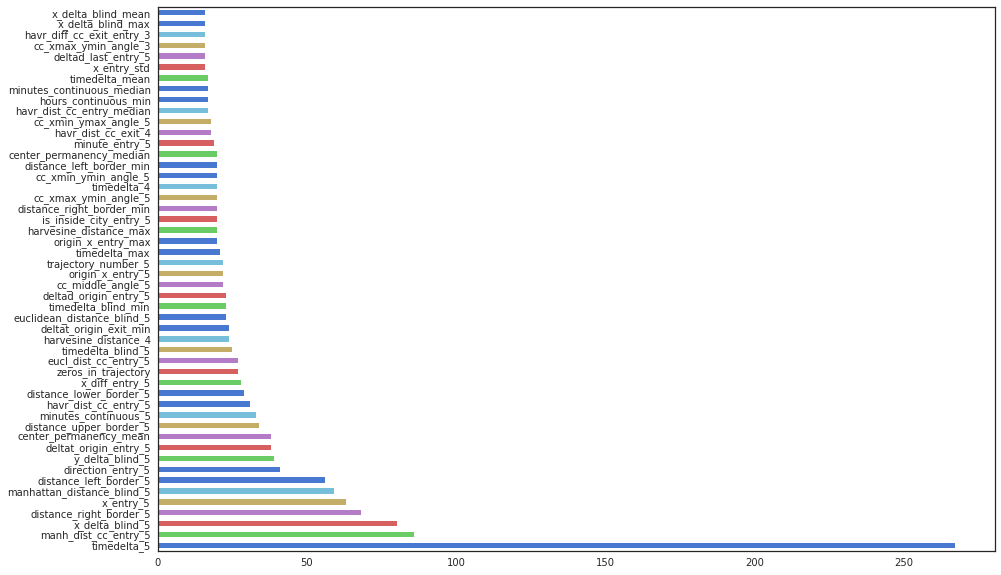

In [165]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(50).plot(kind='barh')

In [166]:
data_test = data_sequence[data_sequence.hash.isin(hashs_test)]
#data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [167]:
data_test.shape

(33515, 713)

In [168]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [169]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [170]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [179]:
pd.Series(yhat).value_counts()

0.0    25034
1.0     8481
dtype: int64

In [172]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [173]:
submission.to_csv('../data/submission1_victor_julio.csv', index=False)

# Preprocessed Data Saving

In [ ]:
data_sequence.to_hdf('../data/preprocessed/data_sequence.hdf', key='final', mode='w')